In [1]:
import numpy as np
import pandas as pd

def generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs):
    n_ratings = 10
    n_columns = 12  # Including withdraw and default columns
    matrix = np.zeros((n_ratings, n_columns))
    
    stddev = withdraw_prob / 10
    
    # Specified default rates
    default_rates = np.array([0.00005, 0.0001, 0.0004, 0.0009, 0.0025, 
                              0.007, 0.0128, 0.0601, 0.1575, 0.3537])

    for i in range(n_ratings):
        # Assign specified default probability
        default_prob = default_rates[i]
        
        # Assign withdraw probability following a normal distribution centered around withdraw_prob
        withdraw_prob_sample = np.random.normal(withdraw_prob, stddev)
        
        # Ensure withdraw probability is within the valid range [0, 1]
        withdraw_prob_sample = max(0, min(withdraw_prob_sample, 1))
        
        # Calculate the remaining probability for other transitions
        remaining_prob = 1 - default_prob - withdraw_prob_sample
        
        # Set main diagonal probability
        main_diagonal = np.random.normal(main_diagonal_probs[i], main_diagonal_probs[i]/100)
        
        # Calculate side probabilities based on the number of adjacent ratings
        num_adjacent_ratings = min(i, n_ratings - 1 - i)
        if i == 0:  # Top rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (downwards)
        elif i == 9:  # Bottom rating
            side_prob = (remaining_prob - main_diagonal) / 2  # Only two adjacent ratings (upwards)
        elif num_adjacent_ratings == 1:
            side_prob = (remaining_prob - main_diagonal) / 3
        elif num_adjacent_ratings == 2:
            side_prob = (remaining_prob - main_diagonal) / 4
        elif num_adjacent_ratings == 3:
            side_prob = (remaining_prob - main_diagonal) / 5
        else:
            side_prob = (remaining_prob - main_diagonal) / 6
        
        # Set main diagonal
        matrix[i, i] = main_diagonal
        
        # Set probabilities for adjacent ratings with randomness
        for j in range(1, 4):
            if i - j >= 0:  # Lower adjacent ratings, i.e. higher ratings
                matrix[i, i - j] = max(0, side_prob * (4 - j) * np.random.uniform(0.7, 0.9))
            if i + j < n_ratings:  # Upper adjacent ratings, i.e. lower ratings
                matrix[i, i + j] = max(0, side_prob * (4 - j) * np.random.uniform(1.1, 1.3))
        
        # Normalize probabilities for other states while keeping main diagonal fixed
        before_i = np.sum(matrix[i, :i])
        after_i = np.sum(matrix[i, i+1:n_ratings])
        total_adjacent_prob = before_i + after_i
        if total_adjacent_prob > 0:
            matrix[i, :i] *= (remaining_prob - main_diagonal) / total_adjacent_prob
            matrix[i, i+1:n_ratings] *= (remaining_prob - main_diagonal) / total_adjacent_prob
        
        matrix[i, -2] = withdraw_prob_sample  # Withdraw probability
        matrix[i, -1] = default_prob  # Default probability

    # Ensure transition probabilities for Rating 1 and Rating 10 are correctly adjusted
    matrix[0, 1] = max(matrix[0, 1], 1e-5)  # Ensure non-zero probability to transition to Rating 2
    matrix[0, 2] = max(matrix[0, 2], 1e-5)  # Ensure non-zero probability to transition to Rating 3
    matrix[9, 8] = max(matrix[9, 8], 1e-5)  # Ensure non-zero probability to transition to Rating 9
    matrix[9, 7] = max(matrix[9, 7], 1e-5)  # Ensure non-zero probability to transition to Rating 8
    
    # Define row and column labels
    row_labels = [f'Rating {i+1}' for i in range(10)]
    column_labels = [f'Rating {i+1}' for i in range(10)] + ['Withdraw', 'Default']

    # Create a DataFrame with labels
    transition_matrix_df = pd.DataFrame(matrix, index=row_labels, columns=column_labels)

    return matrix, transition_matrix_df

# Example usage
withdraw_prob = 0.05  # Centered around value% withdraw probability
# Main diagonal probabilities for each rating
main_diagonal_probs = [0.88, 0.85, 0.83, 0.82, 0.80, 0.77, 0.70, 0.65, 0.60, 0.55]
matrix, transition_matrix_df = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
transition_matrix_df

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Rating 6,Rating 7,Rating 8,Rating 9,Rating 10,Withdraw,Default
Rating 1,0.880735,0.031744,0.021446,0.011580,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054445,0.00005
Rating 2,0.022336,0.862470,0.030117,0.020522,0.009988,0.000000,0.000000,0.000000,0.000000,0.000000,0.054467,0.00010
Rating 3,0.016072,0.027115,0.827824,0.037509,0.023820,0.012988,0.000000,0.000000,0.000000,0.000000,0.054271,0.00040
Rating 4,0.008251,0.016934,0.022665,0.818999,0.039198,0.025963,0.013532,0.000000,0.000000,0.000000,0.053559,0.00090
Rating 5,0.000000,0.009298,0.017315,0.027842,0.807866,0.045371,0.031523,0.015783,0.000000,0.000000,0.042502,0.00250
Rating 6,0.000000,0.000000,0.012554,0.020649,0.033139,0.772815,0.048348,0.034027,0.016657,0.000000,0.054811,0.00700
Rating 7,0.000000,0.000000,0.000000,0.017711,0.033435,0.053977,0.695680,0.073273,0.047601,0.023839,0.041683,0.01280
Rating 8,0.000000,0.000000,0.000000,0.000000,0.019368,0.036733,0.054623,0.647151,0.083462,0.058632,0.039930,0.06010
Rating 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.018121,0.036079,0.055512,0.605068,0.079123,0.048597,0.15750
Rating 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008906,0.018342,0.025817,0.543311,0.049925,0.35370


In [3]:
from scipy.stats import multinomial

def simu_tm_multiyear(obligor, transition_matrix, year):
    n_ratings, n_columns = transition_matrix.shape
    mat = []
    tm = []
    tm_hf = []
    for i in range(year):
        mat.append(np.zeros((n_ratings, n_columns)))
        tm.append(np.zeros((n_columns, n_columns)))
        tm[i][n_columns - 1,n_columns - 1] = 1
        tm[i][n_columns - 2,n_columns - 2] = 1
        tm_hf.append(np.zeros((n_columns-1, n_columns-1)))
        tm_hf[i][n_columns - 2,n_columns - 2] = 1
        tm_hf[i][n_columns - 3,n_columns - 3] = 1       
    df_multiyear = np.zeros((n_ratings, year))
    wd_multiyear = np.zeros((n_ratings, year))
    for i in range(n_ratings):
        n = np.count_nonzero(obligor == i+1)
        mat[0][i,:] = multinomial.rvs(n, transition_matrix[i,:])
        tm[0][i,:] =  mat[0][i,:]/n
        tm_hf[0][i,:-1] = mat[0][i,:-2]/sum(mat[0][i,:-2])*(sum(mat[0][i,:-2])+mat[0][i,-2]/2)/(n - mat[0][i,-2]/2)
        tm_hf[0][i,-1] = 1 - sum(tm_hf[0][i,:-1])
   
    df_multiyear[:,0] = mat[0][:,-1]
    wd_multiyear[:,0] = mat[0][:,-2]  
    if year > 1:
        for j in range(1,year):
            for i in range(n_ratings):
                n = sum(mat[j - 1][:,i])
                if n > 0:
                    mat[j][i,:] = multinomial.rvs(n, transition_matrix[i,:])
                    tm[j][i,:] = mat[j][i,:]/n
                    tm_hf[j][i,:-1] = mat[j][i,:-2]/sum(mat[j][i,:-2])*(sum(mat[j][i,:-2])+mat[j][i,-2]/2)/(n - mat[j][i,-2]/2)
                    tm_hf[j][i,-1] = 1 - sum(tm_hf[j][i,:-1])
            df_multiyear[:,j] = mat[j][:,-1]
            wd_multiyear[:,j] = mat[j][:,-2]         
    return mat, tm, tm_hf, df_multiyear, wd_multiyear

In [4]:
def forward_tm_multiyear(tm_long_run, year):
    # TTC matrix to cumulative TM
    n_ratings, n_columns = tm_long_run.shape
    ctm_fwd = []
    ctm_fwd.append(tm_long_run)
    tm_long_run_hf = np.zeros((n_columns-1, n_columns-1))
    tm_long_run_hf[:-1,:-1] = tm_long_run[:-2,:-2]/np.sum(tm_long_run[:-2,:-2],0)*(np.sum(tm_long_run[:-2,:-2],0)+tm_long_run[:-2,-2]/2)/(1 - tm_long_run[:-2,-2]/2)
    tm_long_run_hf[:-1,-1] = tm_long_run[:-2,-1]/(1 - tm_long_run[:-2,-2]/2)
    tm_long_run_hf[-1,-1] = 1
    ctm_fwd_hf = []
    ctm_fwd_hf.append(tm_long_run_hf)   
    for j in range(year):
        ctm_fwd.append(np.zeros((n_columns, n_columns)))
        ctm_fwd[j+1] = np.matmul(ctm_fwd[j],tm_long_run)
        ctm_fwd_hf.append(np.zeros((n_columns-1, n_columns-1)))
        ctm_fwd_hf[j+1] = np.matmul(ctm_fwd_hf[j],tm_long_run_hf)       
    return ctm_fwd, ctm_fwd_hf

## Case 3 demo code

In [15]:
n_ratings = 10
withdraw_prob = 0.10# Centered around value% withdraw probability
# Main diagonal probabilities for each rating
main_diagonal_probs = [0.80, 0.77, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35]
#main_diagonal_probs = [0.85, 0.85, 0.83, 0.82, 0.80, 0.77, 0.70, 0.65, 0.60, 0.55]

n_obligors = [100000, 200000, 300000, 500000,500000, 400000,300000,20000,10000,5000]
a = np.repeat(range(1,11),n_obligors)
year = 10

tm, tm_df = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)

multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)

oblg_rm = np.zeros((n_ratings, year+1))
oblg_rm[:,0] = n_obligors
for j in range(1,year+1):
    oblg_rm[:,j] = oblg_rm[:,j-1] - multi_wd[:,j-1]

oblg_rm_1 = np.zeros((n_ratings, year*2))
oblg_rm_1[:,0] = n_obligors

for j in range(1,year*2):
    oblg_rm_1[:,j] = oblg_rm[:,int(j/2+0.5)]

### Case 3 Simulation based on real world
### when the model is applied, only long run average TM can be used instead of PIT TM(without macro)
TM_l = np.mean(multi_tm, axis = 0)
pred_ctm_fwd, pred_ctm_fwd_hf = forward_tm_multiyear(TM_l, year)

# assume all WD customers only leaves in the middle of each periods and assume LGD = 1 EAD = 1
PD_2 = np.zeros((n_ratings, year*2))
PD_2_hf = np.zeros((n_ratings, year))
PD_2[:,0] = pred_ctm_fwd[0][:-2,-1]/2
PD_2_hf[:,0] = pred_ctm_fwd_hf[0][:-1,-1]

PD_m_2 = np.zeros((n_ratings, year+1))
WD_m_2 = np.zeros((n_ratings, year+1))

PD_m_2[:,0] = pred_ctm_fwd[0][:-2,-1]
for j in range(1,year+1):
    PD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-1] - pred_ctm_fwd[j-1][:-2,-1])/(1-pred_ctm_fwd[j-1][:-2,-2])
    WD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-2] - pred_ctm_fwd[j-1][:-2,-2])/(1-pred_ctm_fwd[j-1][:-2,-2])

for j in range(1,year*2):
    PD_2[:,j] = PD_m_2[:,int(j/2)]/2
for j in range(1,year):
    PD_2[:,j*2-1] = PD_2[:,j*2-2]/(1-WD_m_2[:,j-1])
    PD_2_hf[:,j] = (pred_ctm_fwd_hf[j][:-1,-1] - pred_ctm_fwd_hf[j-1][:-1,-1])  

t=10

ecl1_tmp = PD_2[:,:(t*2)]*oblg_rm_1[:,:(t*2)]
ecl1 = np.zeros((n_ratings, year))
for j in range(year):
    ecl1[:,j] = ecl1_tmp[:,2*j] + ecl1_tmp[:,2*j+1]
ecl1_hf = PD_2_hf[:,:t]*oblg_rm[:,:t]
loss = multi_df[:,:t]

print(sum(ecl1)/sum(loss)-1,sum(ecl1_hf)/sum(loss)-1)

[-0.0545379  -0.02343008 -0.04347955 -0.04738865 -0.03938798 -0.00814357
  0.00613785  0.04106195  0.06699766  0.06306005] [0.05497773 0.04877381 0.02782455 0.02583955 0.03967097 0.08367003
 0.11253543 0.1687521  0.22087691 0.29407338]


## Case 3 simulation code, with example of WTD=0.05, period 1, 5 and 10

Time 1 Stats: {'Min': -0.05582841649055592, 'Max': 0.004523485686651174, 'Mean': -0.024895946766334685, 'Std': 0.008069285010434059} {'Min': -0.006393360217260113, 'Max': 0.059051039302512986, 'Mean': 0.025726732679374732, 'Std': 0.008506422452160144}
Time 5 Stats: {'Min': -0.03838479355386615, 'Max': 0.005393670850437626, 'Mean': -0.017658271566508423, 'Std': 0.005516509842580448} {'Min': -0.002959862427724058, 'Max': 0.06722238964477789, 'Mean': 0.029969083172981435, 'Std': 0.009402731303664676}
Time 10 Stats: {'Min': -0.012220576462335209, 'Max': 0.0427338122145402, 'Mean': 0.014608607500956435, 'Std': 0.006965800694179388} {'Min': 0.06004597389052546, 'Max': 0.18038925362268965, 'Mean': 0.12029796975846607, 'Std': 0.01516605527350834}


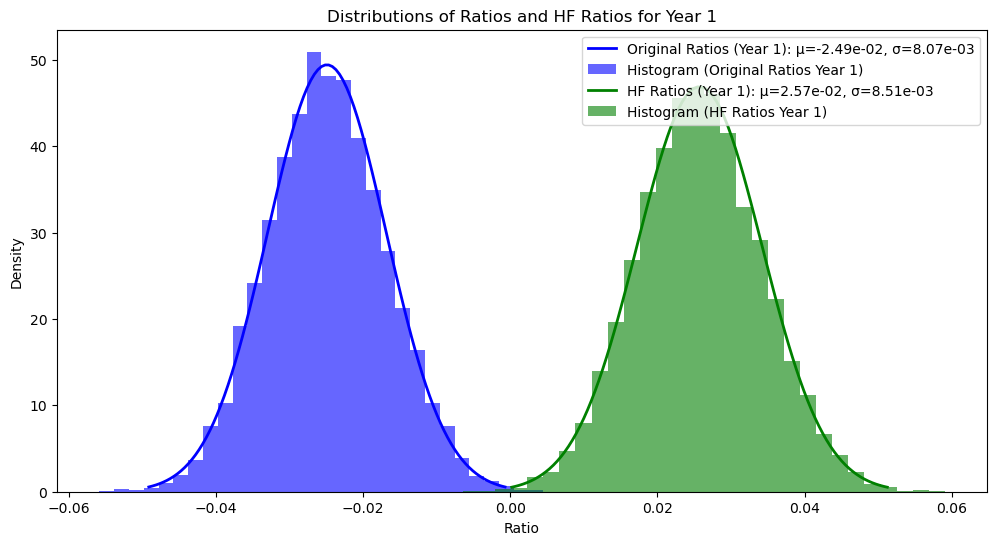

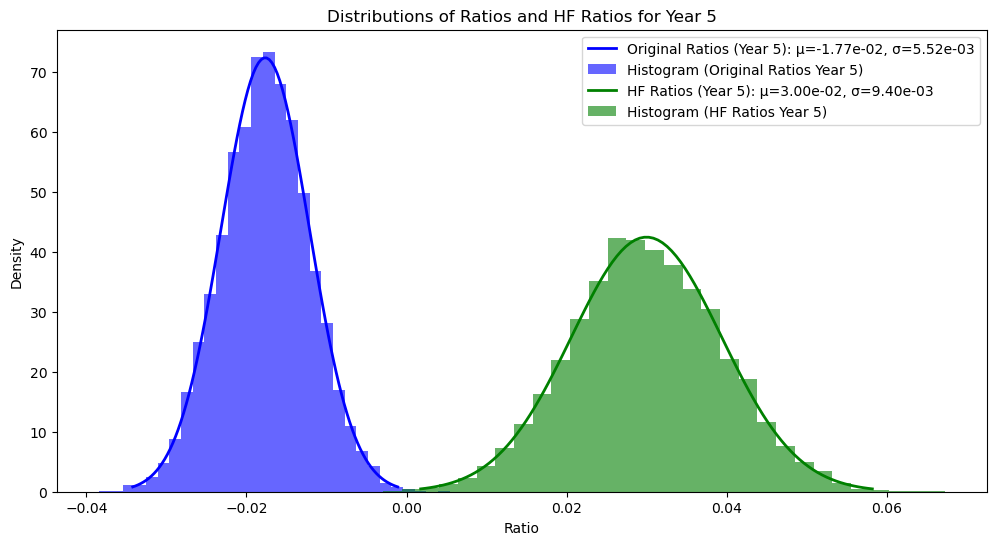

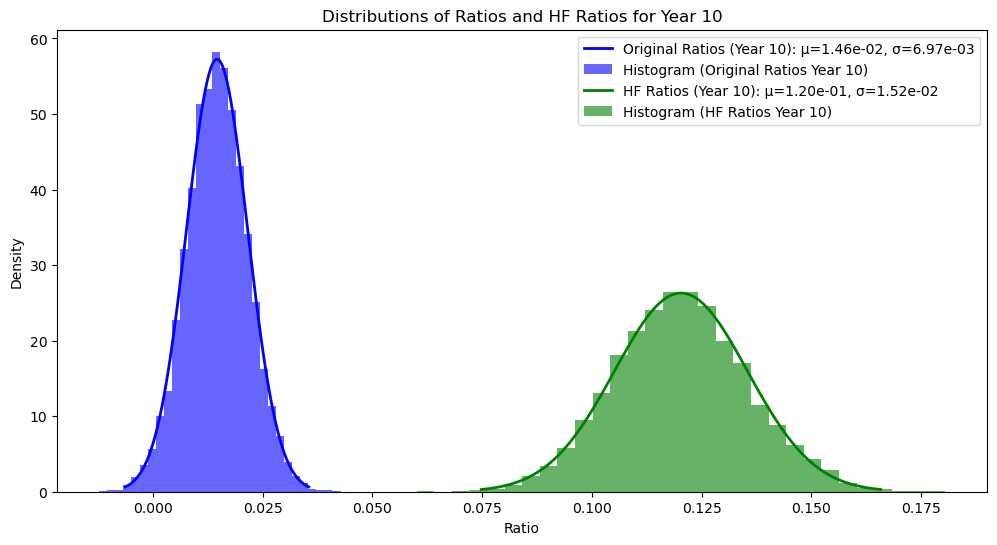

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_credit_risk(withdraw_prob, main_diagonal_probs, n_simulations=10000, year=10):
    n_ratings = 10
    n_obligors = [100000, 200000, 300000, 500000, 500000, 400000, 300000, 20000, 10000, 5000]
    a = np.repeat(range(1, 11), n_obligors)

    ratios = []
    ratios_hf = []

    for _ in range(n_simulations):  # Run simulations
        # Generate transition matrix
        tm, _ = generate_credit_transition_matrix_with_withdraw_prob(withdraw_prob, main_diagonal_probs)
        
        # Simulate the transition matrices and defaults
        multi_mat, multi_tm, multi_tm_hf, multi_df, multi_wd = simu_tm_multiyear(a, tm, year+1)
        
        # Compute remaining obligations
        oblg_rm = np.zeros((n_ratings, year+1))
        oblg_rm[:,0] = n_obligors
        for j in range(1, year+1):
            oblg_rm[:,j] = oblg_rm[:,j-1] - multi_wd[:,j-1]
        
        oblg_rm_1 = np.zeros((n_ratings, year*2))
        oblg_rm_1[:,0] = n_obligors
        for j in range(1, year*2):
            oblg_rm_1[:,j] = oblg_rm[:,int(j/2+0.5)]
        
        # Case 3 Simulation
        TM_l = np.mean(multi_tm, axis=0)
        pred_ctm_fwd, pred_ctm_fwd_hf = forward_tm_multiyear(TM_l, year)
        
        PD_2 = np.zeros((n_ratings, year*2))
        PD_2_hf = np.zeros((n_ratings, year))
        PD_2[:,0] = pred_ctm_fwd[0][:-2,-1]/2
        PD_2_hf[:,0] = pred_ctm_fwd_hf[0][:-1,-1]
        
        PD_m_2 = np.zeros((n_ratings, year+1))
        WD_m_2 = np.zeros((n_ratings, year+1))
        
        PD_m_2[:,0] = pred_ctm_fwd[0][:-2,-1]
        for j in range(1, year+1):
            PD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-1] - pred_ctm_fwd[j-1][:-2,-1]) / (1 - pred_ctm_fwd[j-1][:-2,-2])
            WD_m_2[:,j] = (pred_ctm_fwd[j][:-2,-2] - pred_ctm_fwd[j-1][:-2,-2]) / (1 - pred_ctm_fwd[j-1][:-2,-2])

        for j in range(1, year*2):
            PD_2[:,j] = PD_m_2[:,int(j/2)]/2
        for j in range(1, year):
            PD_2[:,j*2-1] = PD_2[:,j*2-2] / (1 - WD_m_2[:,j-1])
            PD_2_hf[:,j] = (pred_ctm_fwd_hf[j][:-1,-1] - pred_ctm_fwd_hf[j-1][:-1,-1])
        
        t = 10
        ecl1_tmp = PD_2[:,:(t*2)] * oblg_rm_1[:,:(t*2)]
        ecl1 = np.zeros((n_ratings, year))
        for j in range(year):
            ecl1[:,j] = ecl1_tmp[:,2*j] + ecl1_tmp[:,2*j+1]
        ecl1_hf = PD_2_hf[:,:t] * oblg_rm[:,:t]
        loss = multi_df[:,:t]
        
        # Use sum() instead of np.nansum()
        ratio = sum(ecl1) / sum(loss) - 1
        ratio_hf = sum(ecl1_hf) / sum(loss) - 1
        
        ratios.append(ratio)
        ratios_hf.append(ratio_hf)

    # Convert to numpy arrays for easier calculations
    ratios = np.array(ratios)
    ratios_hf = np.array(ratios_hf)

    # Extract the 0, 4, and 9 indices corresponding to time 1, 5, and 10
    ratios_time_1 = ratios[:, 0]
    ratios_time_5 = ratios[:, 4]
    ratios_time_10 = ratios[:, 9]

    ratios_hf_time_1 = ratios_hf[:, 0]
    ratios_hf_time_5 = ratios_hf[:, 4]
    ratios_hf_time_10 = ratios_hf[:, 9]

    # Calculate statistics for time 1, 5, and 10
    def calculate_stats(data):
        return {
            "Min": np.min(data),
            "Max": np.max(data),
            "Mean": np.mean(data),
            "Std": np.std(data)
        }

    stats_time_1 = calculate_stats(ratios_time_1)
    stats_time_5 = calculate_stats(ratios_time_5)
    stats_time_10 = calculate_stats(ratios_time_10)

    stats_hf_time_1 = calculate_stats(ratios_hf_time_1)
    stats_hf_time_5 = calculate_stats(ratios_hf_time_5)
    stats_hf_time_10 = calculate_stats(ratios_hf_time_10)

    print("Time 1 Stats:", stats_time_1, stats_hf_time_1)
    print("Time 5 Stats:", stats_time_5, stats_hf_time_5)
    print("Time 10 Stats:", stats_time_10, stats_hf_time_10)

    # Plot the distributions for Time 1, 5, and 10
    for i, (ratios_t, ratios_hf_t, time_label) in enumerate(zip(
        [ratios_time_1, ratios_time_5, ratios_time_10],
        [ratios_hf_time_1, ratios_hf_time_5, ratios_hf_time_10],
        ["Year 1", "Year 5", "Year 10"]
    )):
        plt.figure(figsize=(12, 6))

        # Fit and plot the normal distribution for `ratios_t`
        mu_ratio, std_ratio = norm.fit(ratios_t)
        x_ratio = np.linspace(mu_ratio - 3*std_ratio, mu_ratio + 3*std_ratio, 100)
        p_ratio = norm.pdf(x_ratio, mu_ratio, std_ratio)
        plt.plot(x_ratio, p_ratio, 'blue', lw=2, label=f'Original Ratios ({time_label}): μ={mu_ratio:.2e}, σ={std_ratio:.2e}')
        plt.hist(ratios_t, bins=30, density=True, alpha=0.6, color='blue', label=f'Histogram (Original Ratios {time_label})')

        # Fit and plot the normal distribution for `ratios_hf_t`
        mu_ratio_hf, std_ratio_hf = norm.fit(ratios_hf_t)
        x_ratio_hf = np.linspace(mu_ratio_hf - 3*std_ratio_hf, mu_ratio_hf + 3*std_ratio_hf, 100)
        p_ratio_hf = norm.pdf(x_ratio_hf, mu_ratio_hf, std_ratio_hf)
        plt.plot(x_ratio_hf, p_ratio_hf, 'green', lw=2, label=f'HF Ratios ({time_label}): μ={mu_ratio_hf:.2e}, σ={std_ratio_hf:.2e}')
        plt.hist(ratios_hf_t, bins=30, density=True, alpha=0.6, color='green', label=f'Histogram (HF Ratios {time_label})')

        # Customize the plot
        plt.title(f'Distributions of Ratios and HF Ratios for {time_label}')
        plt.xlabel('Ratio')
        plt.ylabel('Density')
        plt.legend()

        # Show the plot
        plt.show()

# Example usage:
simulate_credit_risk(withdraw_prob=0.05, main_diagonal_probs=[0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40], n_simulations=10000)

## Withdraw Rate = 0.10, year 1, 5, and 10 errors:

Time 1 Stats: {'Min': -0.0833243490008041, 'Max': -0.010386080431825873, 'Mean': -0.05001677248327901, 'Std': 0.008179315551050234} {'Min': 0.021214636987004987, 'Max': 0.08985869934063917, 'Mean': 0.05269146290082523, 'Std': 0.009075558925464418}
Time 5 Stats: {'Min': -0.061022472961921315, 'Max': 0.0009434745919605358, 'Mean': -0.027896857444123294, 'Std': 0.008272868532828171} {'Min': 0.0023572306303256685, 'Max': 0.1479882382994968, 'Mean': 0.06813056405607082, 'Std': 0.018833486730163766}
Time 10 Stats: {'Min': 0.017976586974795872, 'Max': 0.1238328231802821, 'Mean': 0.07114601414162851, 'Std': 0.013764271515775807} {'Min': 0.18379648029236284, 'Max': 0.43496708442705123, 'Mean': 0.3047350040275334, 'Std': 0.03625571651454797}


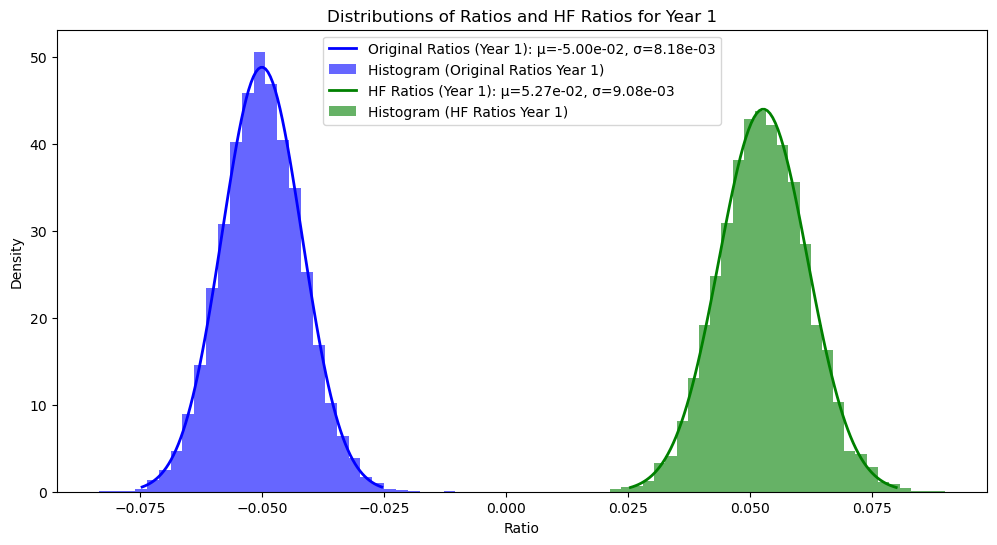

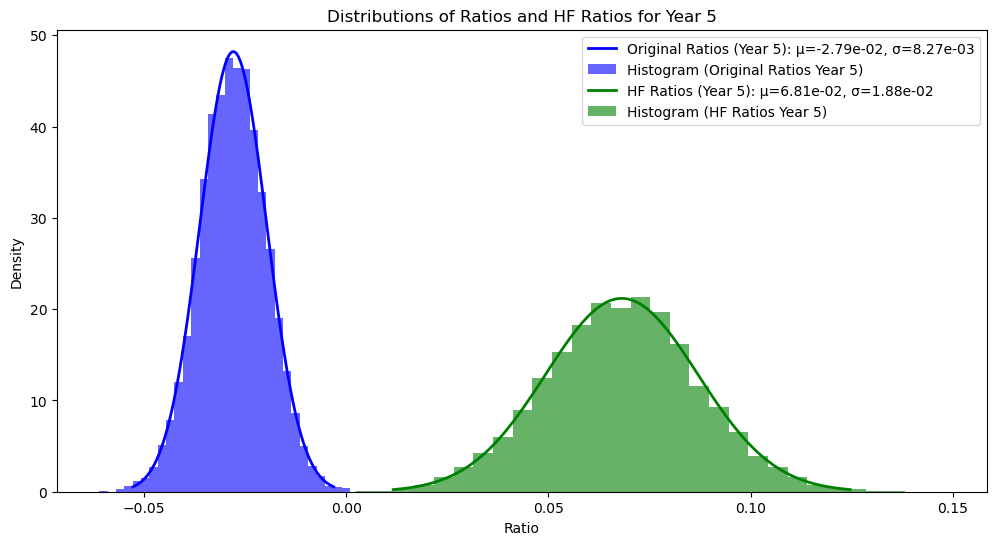

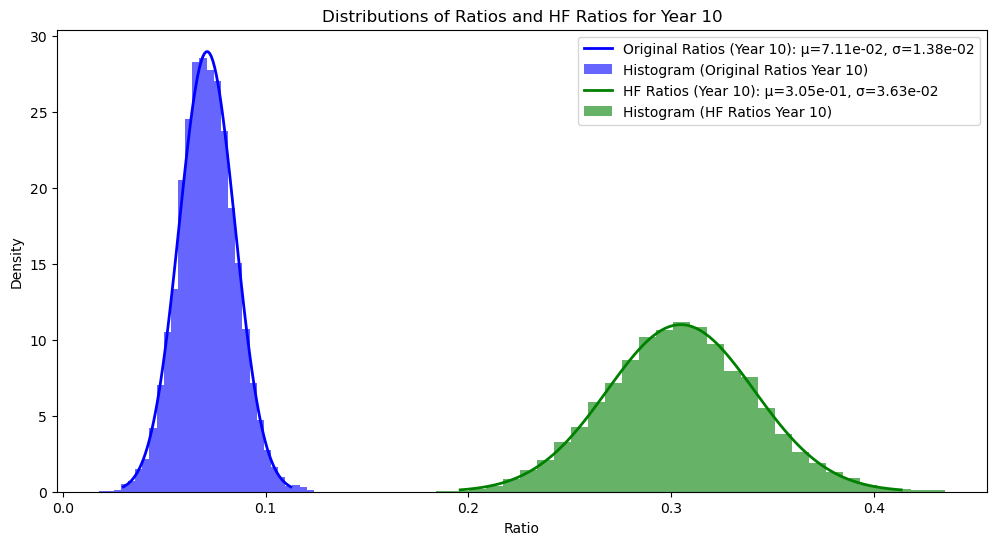

In [30]:
simulate_credit_risk(withdraw_prob=0.1, main_diagonal_probs=[0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35], n_simulations=10000)

## Withdraw Rate = 0.03, year 1, 5, and 10 errors:

Time 1 Stats: {'Min': -0.04816064741052817, 'Max': 0.013580754861639344, 'Mean': -0.014982212564860918, 'Std': 0.007999115470669534} {'Min': -0.01925302885147795, 'Max': 0.045612233619405806, 'Mean': 0.015247807198044751, 'Std': 0.00824233224448271}
Time 5 Stats: {'Min': -0.030188149364558936, 'Max': 0.00901407298025414, 'Mean': -0.011879701063639106, 'Std': 0.0050001134963554485} {'Min': -0.009053597022396942, 'Max': 0.04271579070219045, 'Mean': 0.016948658112857385, 'Std': 0.006692370882701893}
Time 10 Stats: {'Min': -0.01878060263390713, 'Max': 0.027716346927743052, 'Mean': 0.004584637690656939, 'Std': 0.0055885692666652175} {'Min': 0.0330965332939237, 'Max': 0.10372654909929269, 'Mean': 0.06666469865918806, 'Std': 0.00952885106395386}


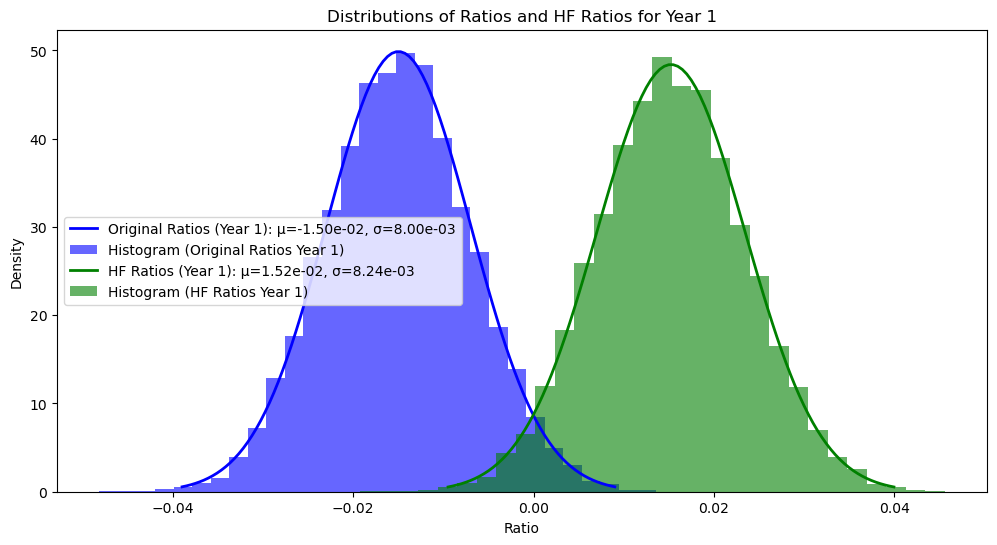

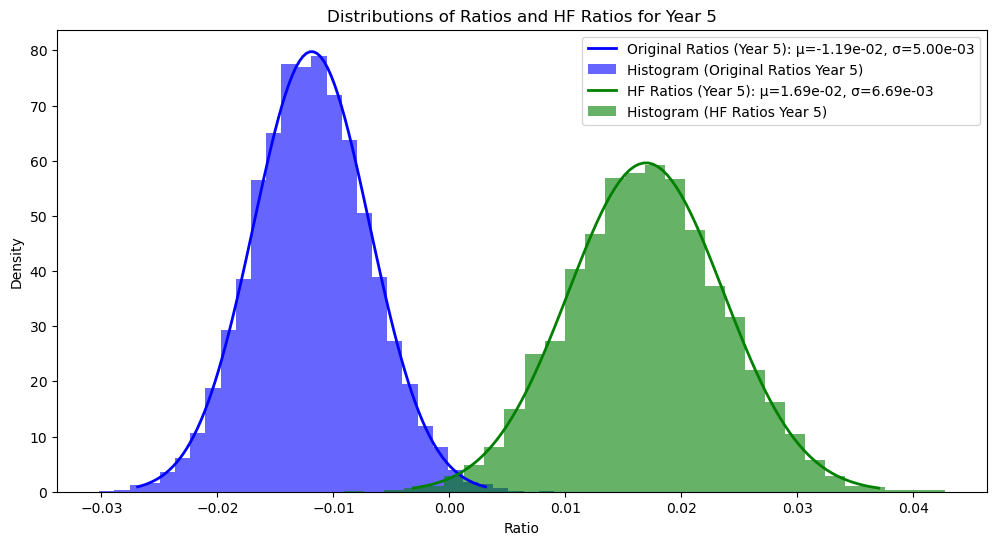

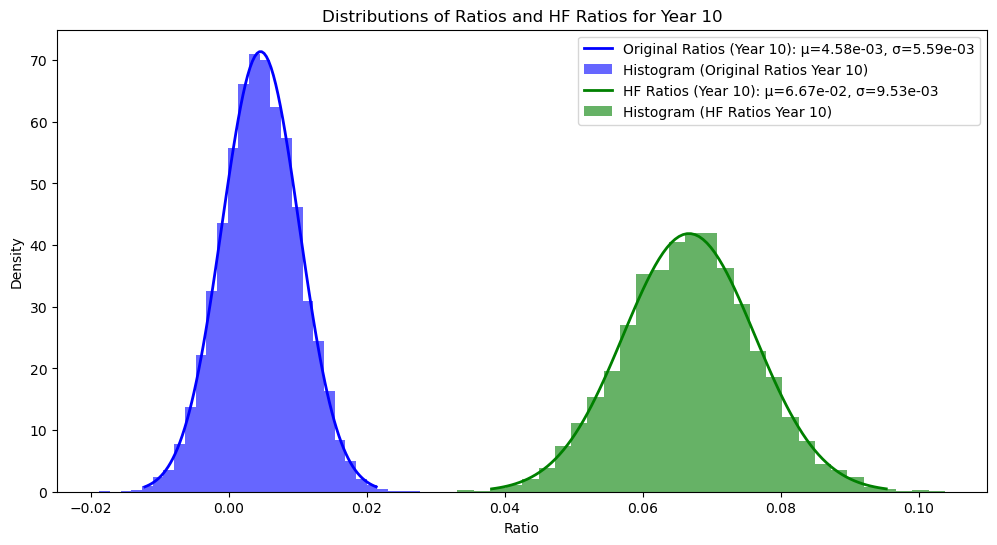

In [31]:
simulate_credit_risk(withdraw_prob=0.03, main_diagonal_probs=[0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45], n_simulations=10000)